In [1]:
import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import yaml
import glob, os
import json
import importlib
import itertools
import loadcoraldata_utils as coralutils

from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


In [4]:
startpath = "../Images/AppData/projections" # Where uncorrected classifications from Jarrett are stored
folders = sorted(os.listdir(startpath))

file_proj = []
file_height = []
file_class = []
for folder in folders:
    currentpath = os.path.join(startpath,folder)
    file_proj.append([f for f in sorted(os.listdir(currentpath)) if ("transect" in f)])
    file_height.append([f for f in sorted(os.listdir(currentpath)) if ("height" in f)])
    file_class.append([f for f in sorted(os.listdir(currentpath)) if not("transect" in f or "height" in f)])

file_proj = list(itertools.chain(*file_proj))
file_height = list(itertools.chain(*file_height))

# Because file folder has to have name of one of the official classes (due to Keras working this way)
# image_savepath = "../Images/Jarrett_3d/Images/No Data"
# class_savepath = "../Images/Jarrett_3d/Classifications/No Data"
# gray_savepath = "../Images/Jarrett_3d/Truthmap_Gray/No Data"

<IPython.core.display.Javascript object>


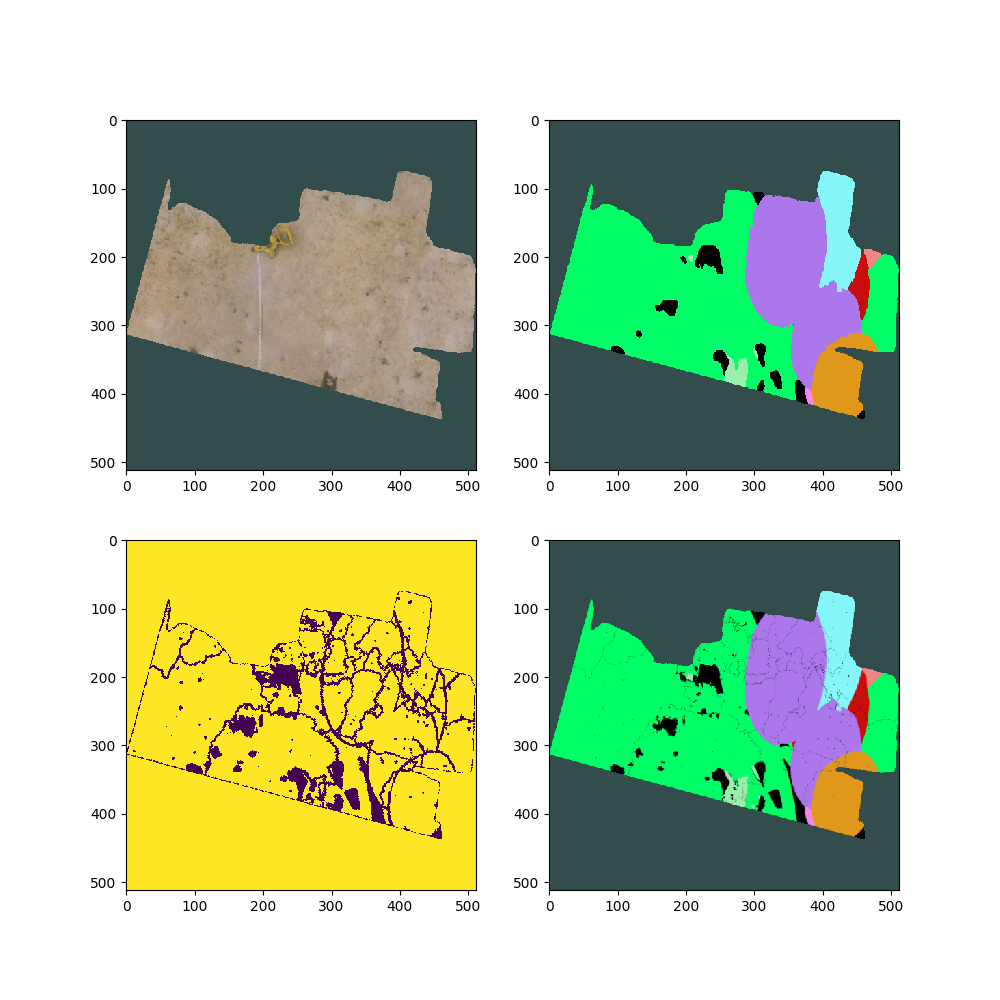

In [3]:
surroundingarea = 5
count = 0
for f in range(len(folders)):
#     print(os.path.join(startpath,folders[f],file_proj[f]))
    img = cv2.cvtColor(cv2.imread(os.path.join(startpath,folders[f],file_proj[f]), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    for fc in range(len(file_class[f])):
        img_class = cv2.cvtColor(cv2.imread(os.path.join(startpath,folders[f],file_class[f][fc]), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        img_class_orig = np.copy(img_class)
        ysize, xsize, channels = img.shape

        img_filter = np.zeros((ysize, xsize)) # contains all areas that have something classified, or is out of bounds
        for k in coralcolors_dict:
            c = coralcolors_dict[k].lstrip("#")
            c_RGB = tuple(int(c[i:i+2], 16) for i in (0, 2, 4))
            if k == "OutofBounds":
                y,x = np.where(np.all(img == np.asarray(c_RGB, dtype=np.uint8), axis=-1))
                img_class[y,x] = np.asarray(c_RGB, dtype=np.uint8)
                    
            y,x = np.where(np.all(img_class == np.asarray(c_RGB, dtype=np.uint8), axis=-1))
            img_filter[y,x] = 1


        perc_filled = np.sum(img_filter)/(ysize*xsize) * 100 # percentage filled, including out of bounds

        if perc_filled > 80: # only save if we have over 80% filled area
            yy, xx = np.where(img_filter == 0)
            # fill in unclassified areas with surroudingarea KNN
            for j,i in zip(yy,xx):
                crop_len = int((surroundingarea-1)/2)
                found_replace = False
                while found_replace is False:
                    tempy_min = max(j-crop_len, 0)
                    tempy_max = min(j+crop_len+1, ysize)
                    tempx_min = max(i-crop_len, 0)
                    tempx_max = min(i+crop_len+1, xsize)
                    truthmap_patch = img_class[tempy_min:tempy_max, tempx_min:tempx_max,:]
                    unq, unq_count = np.unique(truthmap_patch.reshape(-1, truthmap_patch.shape[2]), return_counts=True, axis=0)

                    if len(unq) > 0:
                        found_replace = True
                    else:
                        crop_len += 1
                maxidx = np.argmax(unq_count)
                img_class[j,i] = unq[maxidx]
                
                
                ax.imshow(img_truthgray.astype(int), interpolation='nearest', cmap=cmap, norm=norm)
            # Don't run this unless if you want to write new files to path
#             cv2.imwrite(os.path.join(image_savepath, "Coral" + str(count).zfill(8) + ".png"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#             cv2.imwrite(os.path.join(class_savepath, "Coral" + str(count).zfill(8) + ".png"), cv2.cvtColor(img_class, cv2.COLOR_RGB2BGR))
            count += 1
    
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
ax.imshow(img)
ax = plt.subplot(2,2,2)
ax.imshow(img_class)
ax = plt.subplot(2,2,3)
ax.imshow(img_filter)
ax = plt.subplot(2,2,4)
ax.imshow(img_class_orig)
plt.show()

In [13]:
def transform_RGB2Gray(RGBpath, Graypath, cmap, class_dict):
    files = [f for f in os.listdir(RGBpath) if os.path.isfile(os.path.join(RGBpath,f))]
    classvalues = [class_dict[k] for k in class_dict]
    cmap_len = len(cmap.colors)
    for f in files:
        BGRpatch = cv2.imread(os.path.join(RGBpath,f))
        Graypatch = np.zeros((BGRpatch.shape[0],BGRpatch.shape[1]), dtype=np.uint8)
        for i in range(cmap_len):
            y,x = np.where(np.all(BGRpatch == np.asarray(np.asarray(cmap(i)[-2::-1])*255, dtype=np.uint8), axis=-1))
            Graypatch[y,x] = np.uint8(classvalues[i]*255/cmap_len)
        cv2.imwrite(os.path.join(Graypath,f), Graypatch)
        
cmap = []
coral_dict = {}
counter = 0
for k in coralcolors_dict.keys():
    cmap.append(coralcolors_dict[k])
    coral_dict[k] = counter
    counter += 1

cmap = colors.ListedColormap(cmap)

transform_RGB2Gray(class_savepath, gray_savepath, cmap, coral_dict)

In [18]:
print(coral_dict)
coral_num = {}
for k in coral_dict.keys():
    coral_num[k] = 0

files = [f for f in os.listdir(class_savepath) if os.path.isfile(os.path.join(class_savepath,f))]
cmap_len = len(cmap.colors)
keys = list(coral_num.keys())

for f in files:
    BGRpatch = cv2.imread(os.path.join(class_savepath,f))
    for i in range(cmap_len):
        y,x = np.where(np.all(BGRpatch == np.asarray(np.asarray(cmap(i)[-2::-1])*255, dtype=np.uint8), axis=-1))
        coral_num[keys[i]] += len(y)
print(coral_num)


{'No Data': 0, 'OutofBounds': 1, 'Unknown': 2, 'Bare Substratum': 3, 'Acroporidae': 4, 'Poritidae': 5, 'Gorgoniidae': 6, 'Merulinidae': 7, 'Montastraeidae': 8, 'Mussidae': 9, 'Invertebrate': 10, 'Agariciidae': 11, 'Siderastreidae': 12, 'Pocilloporidae': 13, 'Alcyoniidae': 14, 'Fungiidae': 15, 'Green Algae': 16, 'Brown Algae': 17, 'Red Algae': 18, 'Seagrass': 19, 'Mangrove': 20, 'Plexauridae': 21}
{'No Data': 309161, 'OutofBounds': 27004617, 'Unknown': 114903, 'Bare Substratum': 22195559, 'Acroporidae': 1438890, 'Poritidae': 6481019, 'Gorgoniidae': 0, 'Merulinidae': 0, 'Montastraeidae': 76020, 'Mussidae': 0, 'Invertebrate': 63983, 'Agariciidae': 0, 'Siderastreidae': 324550, 'Pocilloporidae': 3862, 'Alcyoniidae': 0, 'Fungiidae': 0, 'Green Algae': 0, 'Brown Algae': 1289997, 'Red Algae': 9937, 'Seagrass': 1238940, 'Mangrove': 0, 'Plexauridae': 0}


<IPython.core.display.Javascript object>


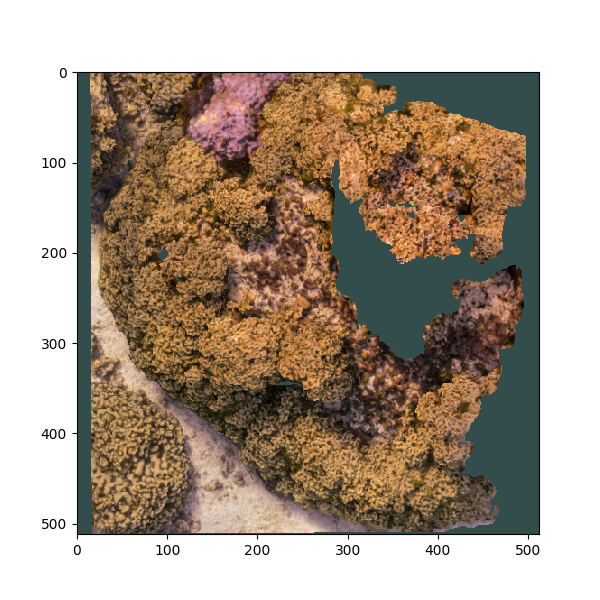

In [10]:
testfile = "Coral00000000.png"
testfile_imgpath = os.path.join(image_savepath, testfile)
testfile_classpath = os.path.join(gray_savepath, testfile)

img = coralutils.CoralData(testfile_imgpath, load_type="cv2").image[:,:,::-1]
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
ax.imshow(img)